In [1]:
import pandas as pd
import random
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, max_error, mean_absolute_error
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS, add_constant
from xgboost import XGBRegressor

In [10]:
def printRegStatistics(truth, preds):
    print("The RVE is: ", explained_variance_score(truth, preds))
    #print("The rmse is: ", mean_squared_error(truth, preds, squared=False))
    #corr, pval = pearsonr(truth, preds)
    #print("The Correlation Score is is: %6.4f (p-value=%e)"%(corr,pval))
    #print("The Maximum Error is is: ", max_error(truth, preds))
    #print("The Mean Absolute Error is: ", mean_absolute_error(truth, preds))
    
def truthplot(y_test, my_preds):
    plt.figure(figsize=(7,7))
    plt.axline([0, 0], [1, 1])
    plt.scatter(my_preds, y_test)
    plt.axis('square')
    plt.grid()
    plt.show()

def df201718(csv_file, diff = False):
    dataframe = pd.read_csv(csv_file, header = 2)
    dataframe.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis = 1, inplace = True)
    if diff == True:
        diff_years_df = dataframe.copy().drop(['Country Name'], axis = 1)
        diff_years_df = diff_years_df.diff(axis = 1)
        intermediate_df = dataframe['Country Name'].copy()
        dataframe = pd.concat([intermediate_df, diff_years_df], axis = 1)
    dataframe = dataframe[['Country Name', '2017', '2018']]
    dataframe['2017'] = pd.to_numeric(dataframe['2017'])
    dataframe['2018'] = pd.to_numeric(dataframe['2018'])
    dataframe_2017 = dataframe.copy().drop('2018', axis = 1)
    dataframe_2018 = dataframe.copy().drop('2017', axis = 1)
    return dataframe_2017, dataframe_2018

def preparedf(csv_file, diff = False):
    dataframe = pd.read_csv(csv_file)
    names = dataframe['Country Name'].copy()
    dataframe.drop(['Country Name','Country Code', 'Indicator Name', 'Indicator Code'], axis = 1, inplace = True)
    columns = dataframe.columns
    for column in columns:
        dataframe[column] = dataframe[column].astype(float)
    if diff == True:
        dataframe = dataframe.diff(axis = 1)
    dataframe = dataframe.join(names)
    return dataframe

def getxydata(dataframe, k):
    years_combinations, list_X_values, columns_name= [], [], []
    for number in range(1960, 2017 - k):
        number_list = []
        for i in range(1, k + 1):
            number_list.append(number + i)
        years_combinations.append(number_list)
    for country in dataframe['Country Name'].values:
        for combination in years_combinations:
            number_list = []
            for number in combination:
                value = dataframe[str(number)][dataframe['Country Name'] == country].values.astype(float)
                number_list.append(value.item())
            list_X_values.append(number_list)
    for numeric in reversed(range(k)):
        columns_name.append('t-' + str(numeric))
    new_dataframe = pd.DataFrame(list_X_values, columns = columns_name)
    new_dataframe = new_dataframe.dropna()
    X_data = new_dataframe.copy().drop('t-0', axis = 1)
    y_data = new_dataframe['t-0'].copy()
    return X_data, y_data

def getxtestytruth(dataframe, dataframe_new_year, years_to_consider_before, year_to_predict, chosen_countries, dataframe_preds_2017):
    X_test, truth_values = [], []
    for country in chosen_countries:
        value_list = []
        if year_to_predict == 2017:
            for number in range(year_to_predict - years_to_consider_before, year_to_predict):
                value_list.append(dataframe[str(number)][dataframe['Country Name'] == country].values.astype(float).item())
            X_test.append(value_list)
            truth_values.append(dataframe_new_year['2017'][dataframe_new_year['Country Name'] == country].values.astype(float).item())
        else:
            for number in range(year_to_predict - years_to_consider_before, year_to_predict - 1):
                value_list.append(dataframe[str(number)][dataframe['Country Name'] == country].values.astype(float).item())
            value_list.append(dataframe_preds_2017['2017'][dataframe_preds_2017['Country Name'] == country].values.astype(float).item())
            X_test.append(value_list)
            truth_values.append(dataframe_new_year['2018'][dataframe_new_year['Country Name'] == country].values.astype(float).item())
    return X_test, truth_values

def preds_2017_df(preds_2017, chosen_countries):
    dataframe_preds_2017 = pd.DataFrame({'Country Name': chosen_countries,'2017': preds_2017})
    return dataframe_preds_2017

def fitevaluate(model, X_data, y_data, X_test, y_test, plots = False):
    X_data = np.array(X_data)
    y_data = np.array(y_data)
    prediction_model = model.fit(X_data, y_data)
    predictions = model.predict(X_test)
    printRegStatistics(y_test, predictions)
    if plots == True:
        truthplot(y_test, predictions)
    return predictions

def allinone(csv_data, csv_201718, model, k, chosen_countries, preds_2017, diff = False, plots = False, desc_predictions = False):
    dataframe = preparedf(csv_data, diff)
    dataframe_2017, dataframe_2018 = df201718(csv_201718, diff)
    X_data, y_data = getxydata(dataframe, k)
    X_test_2017, truth_2017 = getxtestytruth(dataframe, dataframe_2017, k-1 , 2017, chosen_countries, preds_2017)
    print('For ' + str(csv_data))
    print('For 2017:')
    predictions_2017 = fitevaluate(model, X_data, y_data, X_test_2017, truth_2017, plots)
    dataframe_preds_2017 = preds_2017_df(predictions_2017, chosen_countries)
    X_test_2018, truth_2018 = getxtestytruth(dataframe, dataframe_2018, k-1 , 2018, chosen_countries, dataframe_preds_2017)
    print('For 2018:')
    predictions_2018 = fitevaluate(model, X_data, y_data, X_test_2018, truth_2018, plots)
    if desc_predictions == True:
        print(truth_2017)
        print(predictions_2017)
        print(truth_2018)
        print(predictions_2018)
    print('')

In [3]:
# choose 10 random countries
df = pd.read_csv('country_population.csv')
regions = ['AFE','AFW','ARB','CSS','CEB','EAR','EAS','EAP','TEA','EMU','ECS','ECA','TEC','EUU','FCS','HPC','HIC','IBD','IBT','IDB','IDX','IDA','LTE','LCN','LAC','TLA','LDC','LMY','LIC','LMC','MEA','MNA','TMN','MIC','NAC','INX','OED','OSS','PSS','PST','PRE','SST','SAS','TSA','SSF','SSA','TSS','UMC','WLD']
for region in regions:
    index_list = df[df['Country Code'] == region].index
    df = df.drop(index_list)
chosen_countries = list(df['Country Name'].sample(n = 10, random_state = 123).values)
print(chosen_countries)

['United States', 'Uruguay', 'Central African Republic', 'Seychelles', 'Senegal', 'Saudi Arabia', 'India', 'Lesotho', 'Luxembourg', 'Kenya']


In [4]:
allinone('country_population.csv', 'country_population_2017_2018.csv', LinearRegression(), 4, chosen_countries, [], False, False, False)
allinone('fertility_rate.csv', 'fertility_rate_2017_2018.csv', LinearRegression(), 4, chosen_countries, [], False, False, False)
allinone('life_expectancy.csv', 'life_expectancy_2017_2018.csv', LinearRegression(), 4, chosen_countries, [], False, False, False)

For country_population.csv
For 2017:
The RVE is:  0.9998739460738408

For 2018:
The RVE is:  0.9998781915454074

For fertility_rate.csv
For 2017:
The RVE is:  0.8972876827331064

For 2018:
The RVE is:  0.8739256702946505

For life_expectancy.csv
For 2017:
The RVE is:  0.9628262007229536

For 2018:
The RVE is:  0.9573842251584787



For country_population.csv
For 2017:
The RVE is:  0.9998867016917813


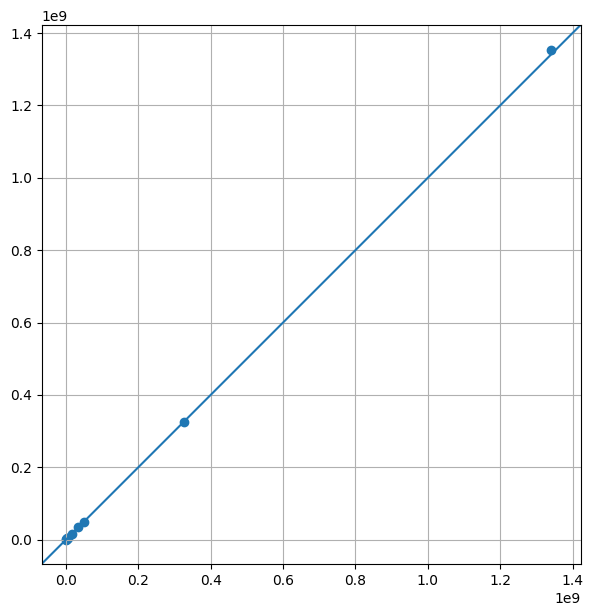

For 2018:
The RVE is:  0.9999599477636851


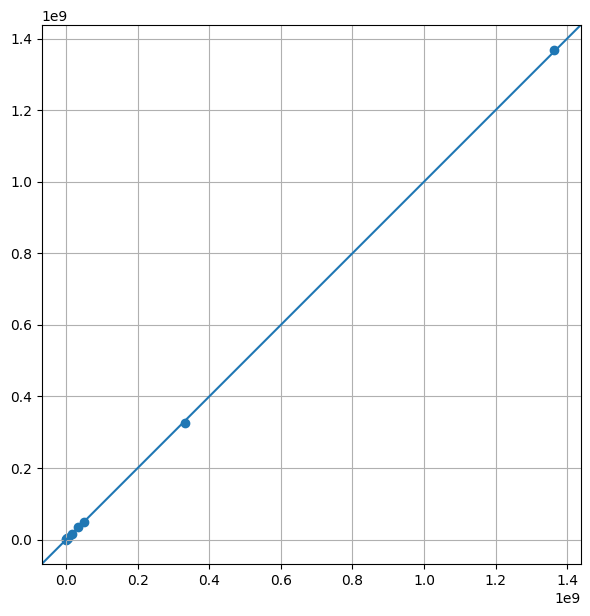

[325122128.0, 3422200.0, 4996741.0, 95843.0, 15157793.0, 34193122.0, 1354195680.0, 2170617.0, 596336.0, 48948137.0]
[3.27319054e+08 3.45833352e+06 4.64556473e+06 9.60605600e+04
 1.58020583e+07 3.29085800e+07 1.34038312e+09 2.23461958e+06
 5.95463940e+05 4.95305487e+07]
[326838199.0, 3427042.0, 5094780.0, 96762.0, 15574909.0, 35018133.0, 1369003306.0, 2198017.0, 607950.0, 49953304.0]
[3.31941134e+08 3.48158060e+06 4.70274141e+06 9.67097300e+04
 1.61929960e+07 3.35760272e+07 1.36285988e+09 2.26744324e+06
 6.08785690e+05 5.04721981e+07]

For fertility_rate.csv
For 2017:
The RVE is:  0.9064590359382431
For 2018:
The RVE is:  0.8958151881596895

For life_expectancy.csv
For 2017:
The RVE is:  0.9635956816793343
For 2018:
The RVE is:  0.9590006226602843



In [14]:
allinone('country_population.csv', 'country_population_2017_2018.csv', RandomForestRegressor(random_state = 123), 4, chosen_countries, [], False, True, True)
allinone('fertility_rate.csv', 'fertility_rate_2017_2018.csv', RandomForestRegressor(random_state = 123), 4, chosen_countries, [], False, False, False)
allinone('life_expectancy.csv', 'life_expectancy_2017_2018.csv', RandomForestRegressor(random_state = 123), 4, chosen_countries, [], False, False, False)

For country_population.csv
For 2017:
The RVE is:  0.9998447012693061
For 2018:
The RVE is:  0.999780615425082

For fertility_rate.csv
For 2017:
The RVE is:  0.9117746377350042


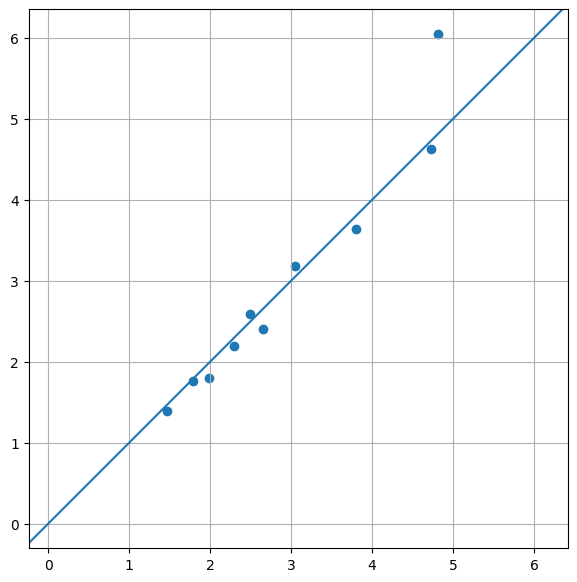

For 2018:
The RVE is:  0.900544559783433


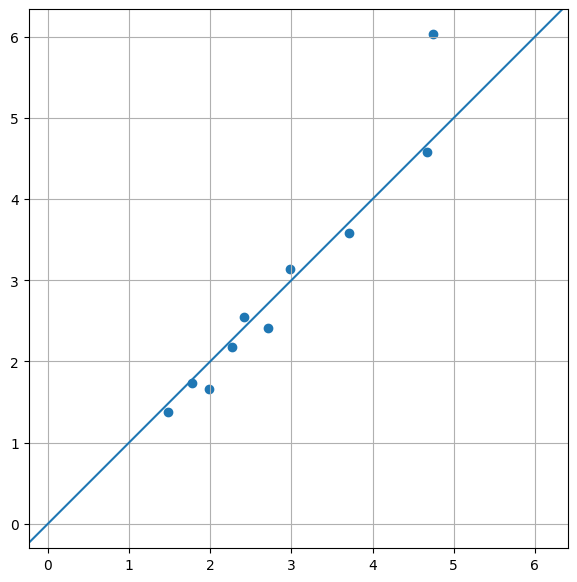

[1.7655, 1.796, 6.048, 2.41, 4.622, 2.584, 2.2, 3.187, 1.39, 3.643]
[1.7845997 1.9879388 4.8077726 2.6575987 4.724874  2.4878771 2.2935693
 3.0432632 1.4733067 3.800857 ]
[1.7295, 1.658, 6.037, 2.41, 4.584, 2.546, 2.177, 3.139, 1.38, 3.58]
[1.7704355 1.9802508 4.745412  2.7069097 4.6678896 2.417402  2.2652256
 2.9858239 1.4814639 3.7147198]

For life_expectancy.csv
For 2017:
The RVE is:  0.9639146506597474


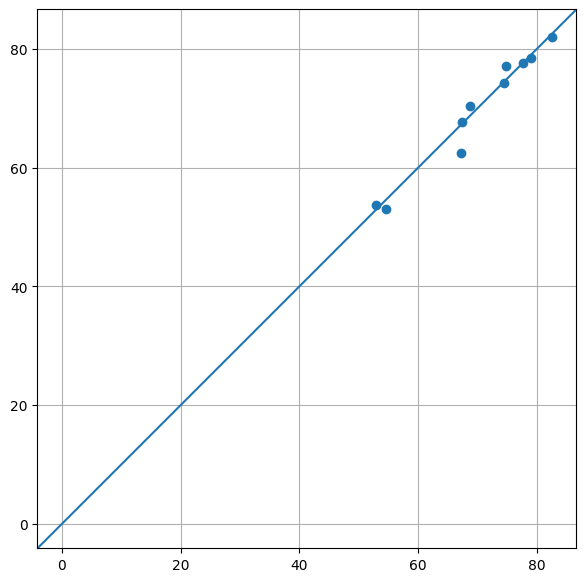

For 2018:
The RVE is:  0.9592015875562794


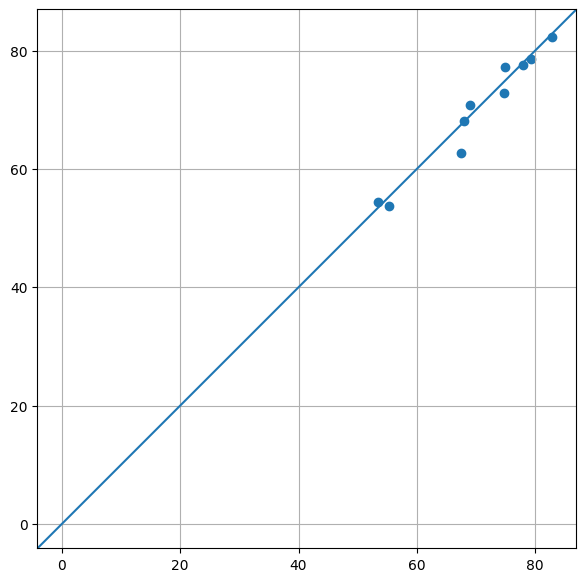

[78.5390243902439, 77.625, 53.721, 74.3, 67.75, 77.16, 70.467, 53.064, 82.0951219512195, 62.481]
[79.01997  77.7164   52.86705  74.56959  67.47117  74.80597  68.77222
 54.691925 82.55566  67.265045]
[78.6390243902439, 77.611, 54.369, 72.8414634146341, 68.097, 77.212, 70.71, 53.733, 82.2951219512195, 62.676]
[79.29834  77.99565  53.46915  74.797264 67.95212  74.95974  68.9887
 55.281303 82.80138  67.534225]



In [13]:
allinone('country_population.csv', 'country_population_2017_2018.csv', XGBRegressor(seed = 123), 4, chosen_countries, [], False, False, False)
allinone('fertility_rate.csv', 'fertility_rate_2017_2018.csv', XGBRegressor(seed = 123), 4, chosen_countries, [], False, True, True)
allinone('life_expectancy.csv', 'life_expectancy_2017_2018.csv', XGBRegressor(seed = 123), 4, chosen_countries, [], False, True, True)

# With diff

In [7]:
allinone('country_population.csv', 'country_population_2017_2018.csv', LinearRegression(), 4, chosen_countries, [], True, False, False)
allinone('fertility_rate.csv', 'fertility_rate_2017_2018.csv', LinearRegression(), 4, chosen_countries, [], True, False, False)
allinone('life_expectancy.csv', 'life_expectancy_2017_2018.csv', LinearRegression(), 4, chosen_countries, [], True, False, False)

For country_population.csv
For 2017:
The RVE is:  0.9988646835435799

For 2018:
The RVE is:  0.9980001030568623

For fertility_rate.csv
For 2017:
The RVE is:  -0.9678933973890036

For 2018:
The RVE is:  -2.1060950351161716

For life_expectancy.csv
For 2017:
The RVE is:  0.326958481587694

For 2018:
The RVE is:  0.10646417601148084



In [8]:
allinone('country_population.csv', 'country_population_2017_2018.csv', RandomForestRegressor(random_state = 123), 4, chosen_countries, [], True, False, False)
allinone('fertility_rate.csv', 'fertility_rate_2017_2018.csv', RandomForestRegressor(random_state = 123), 4, chosen_countries, [], True, False, False)
allinone('life_expectancy.csv', 'life_expectancy_2017_2018.csv', RandomForestRegressor(random_state = 123), 4, chosen_countries, [], True, False, False)

For country_population.csv
For 2017:
The RVE is:  0.999052856510735

For 2018:
The RVE is:  0.9972345591157318

For fertility_rate.csv
For 2017:
The RVE is:  -0.3551411188051674

For 2018:
The RVE is:  -0.7173563670965151

For life_expectancy.csv
For 2017:
The RVE is:  -0.07189598033796285

For 2018:
The RVE is:  0.07738959096800535



In [9]:
allinone('country_population.csv', 'country_population_2017_2018.csv', XGBRegressor(seed = 123), 4, chosen_countries, [], True, False, False)
allinone('fertility_rate.csv', 'fertility_rate_2017_2018.csv', XGBRegressor(seed = 123), 4, chosen_countries, [], True, False, False)
allinone('life_expectancy.csv', 'life_expectancy_2017_2018.csv', XGBRegressor(seed = 123), 4, chosen_countries, [], True, False, False)

For country_population.csv
For 2017:
The RVE is:  0.9984753131484586

For 2018:
The RVE is:  0.9975932091247561

For fertility_rate.csv
For 2017:
The RVE is:  -0.3099625772930381

For 2018:
The RVE is:  -2.378483475251851

For life_expectancy.csv
For 2017:
The RVE is:  0.33152777414402734

For 2018:
The RVE is:  0.12501266245440568

